# ӘР-ТҮРЛІ ДЕРМАТОЛОГИЯЛЫҚ АУРУЛАРДЫ БОЛЖАУ АЛГОРИТМІН ЗЕРТТЕУ

Дермотологиялық ауруларды болжау үшін машиналық оқыту алгоритімдерін құрамыз. <br>

Бұл жұмыста біз 3 түрлі алгоритмді бір бірімен салыстырамыз. 
- 1 алгоритм VGG16 қолданылған CNN <br>
- 2 алгоритм Resnet50 қолданылған CNN <br>
- 3 алгоритм MobileNetV2 қолданылған CNN <br>

Бұл алгоритмдерден Дермотологиялық аурулардың деректер жинағын құрастырып алғаннан кейін шыққан нәтижелерді салыстырып, тестілеп, соңғы нәтижесін шығарамыз.

### Кодта қолданылған әртүрлі компоненттер мен кітапханалар

In [22]:
import numpy as np

import os

import PIL
from PIL import Image

import pathlib
from pathlib import Path

from matplotlib.image import imread
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom


### Деректер жинағымен жұмыс  

<b style="color:red"> ЕСКЕРТУ келесі деректер жинағындағы барлық суреттер 18+ жас шектеулігін талап етеді және аса сезімтал адам болсаңыз суреттерді зерттемес бұрын байқағаныңыз жөн. <b>

In [23]:
data_dir = pathlib.Path(r"C:/Users/assai/datasets/Data")

### Деректер жинағында толық суреттер саны

In [24]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

384


### Деректер жинағында дермотологиялық ауру суреттері

In [25]:
Akne = list(data_dir.glob('Akne/*'))
Dermatit = list(data_dir.glob('Dermatit/*'))
Ekzema = list(data_dir.glob('Ekzema/*'))
Melanoma = list(data_dir.glob('Melanoma/*'))
Ospa = list(data_dir.glob('Ospa/*'))
Psoriaz = list(data_dir.glob('Psoriaz/*'))

Акне


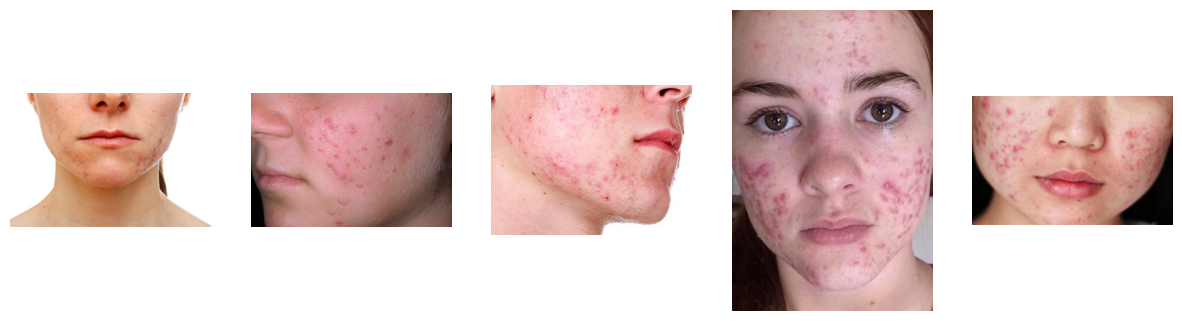

Дерматит


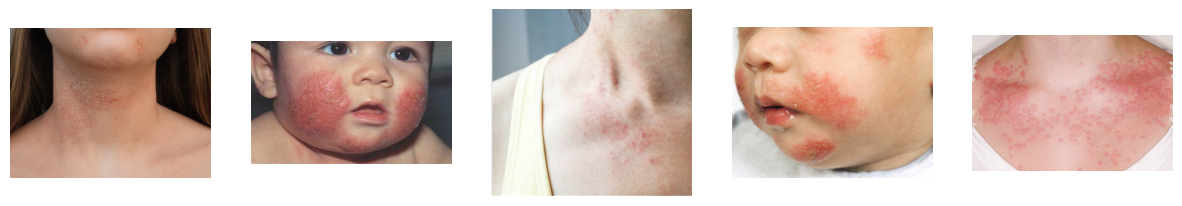

Экзема


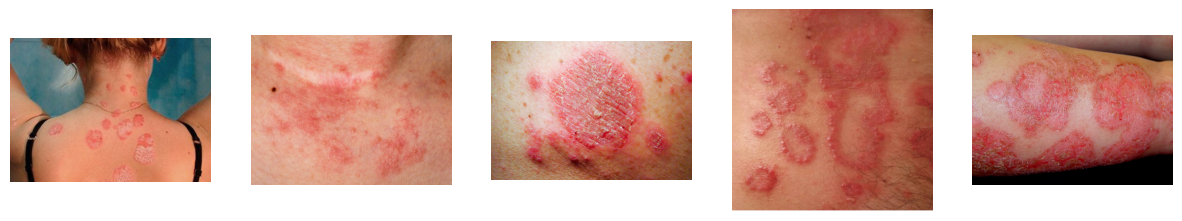

Меланома


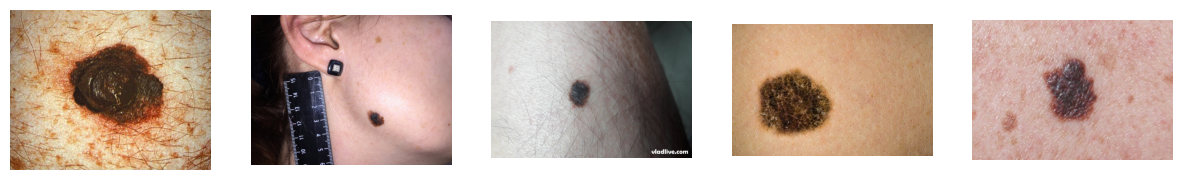

Оспа


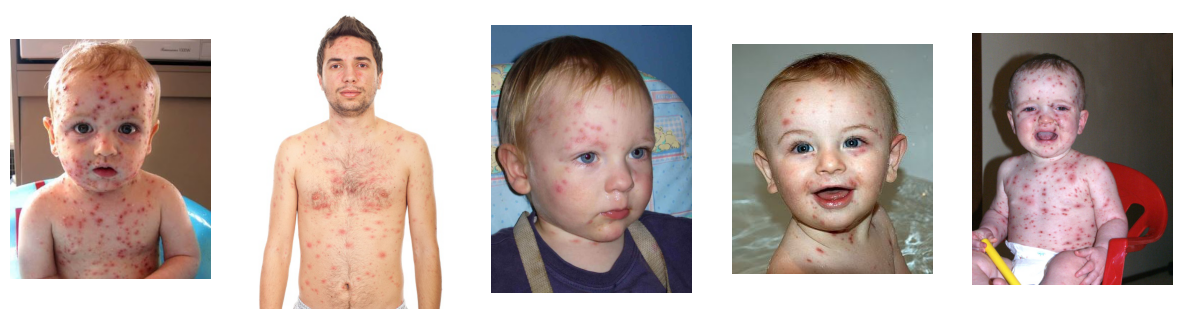

Псориаз


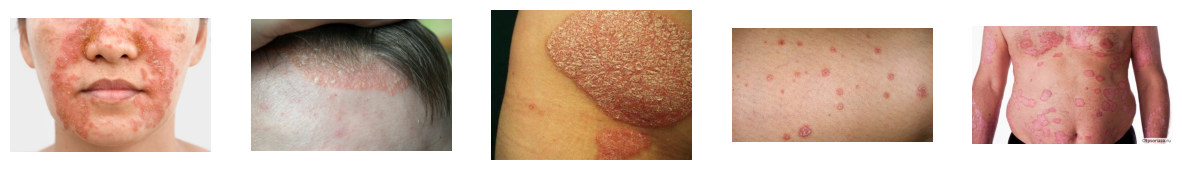

In [26]:
def display_images(image_paths, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 15))

    for i, ax in enumerate(axes):
        img = imread(str(image_paths[i]))
        ax.imshow(img)
        ax.axis('off')

    print(title)
    plt.show()

conditions = [
    Akne, Dermatit, Ekzema,
    Melanoma, Ospa, Psoriaz
]

titles = [
    "Акне", "Дерматит", "Экзема",
    "Меланома", "Оспа",
    "Псориаз"
]

for image_paths, title in zip(conditions, titles):
    display_images(image_paths, title)

#### Кескінді өңдеуге арналған айнымалылар

In [6]:
batch_size = 32
img_height = 224
img_width = 224

#### Жаттықтыруға арналған суреттерден деректер жинағын құру

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 384 files belonging to 6 classes.
Using 308 files for training.


#### Тексеруге арналған суреттерден деректер жинағын құру

In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 384 files belonging to 6 classes.
Using 76 files for validation.


#### Деректер жинағындағы барлық класстар 

In [9]:
class_names = train_ds.class_names
print(class_names)

['Akne', 'Dermatit', 'Ekzema', 'Melanoma', 'Ospa', 'Psoriaz']


#### Жаттықтыру үшін қолданылатын суреттер

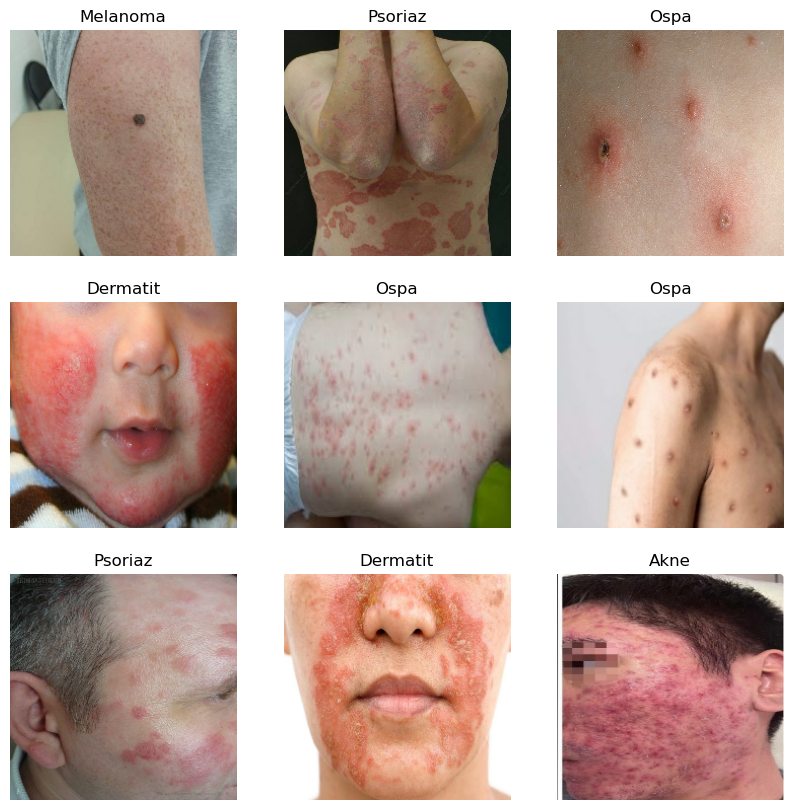

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

#### Кескіндердің әрбір топтамасының пішіні

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


#### Оқыту және тексеру деректер жинақтары үшін кіріс құбырының өнімділігін оңтайландыру әдістері

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(3296).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Қалыпқа келтіру қабатын жасау

In [13]:
normalization_layer = layers.Rescaling(1./255)

#### Map функциясын пайдаланып жаттығу деректер жиынына қалыпқа келтіру деңгейін қолдану

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [15]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

## Классификациялау үшін үлгілерді құру, қолдану

#### VGG16 қолданылған CNN алгоритмі

In [19]:
def create_vgg16_model_with_augmentation(input_shape=(224, 224, 3), num_classes=6):
    model = tf.keras.Sequential([
        data_augmentation,  # Apply data augmentation
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [20]:
vgg16_model = create_vgg16_model(input_shape=(img_height, img_width, 3), num_classes=6)

NameError: name 'create_vgg16_model' is not defined

In [21]:
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

NameError: name 'vgg16_model' is not defined

#### Құрылған үлгіні оқыту

In [ ]:
history = vgg16_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


#### Оқыту және тексеру дәлдігін, сондай-ақ дәуірлердегі оқыту мен тексерудің жоғалуын визуализациялау үшін екі ішкі сызбаны жасау

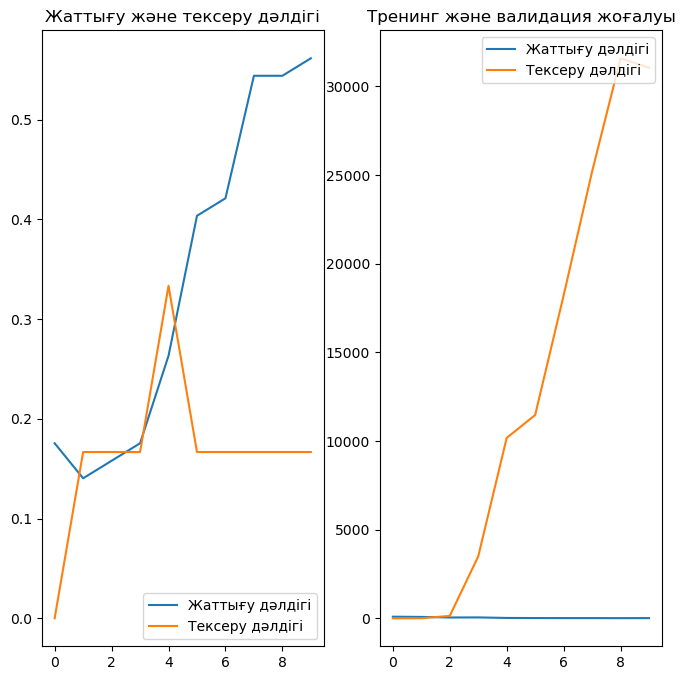

In [110]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Жаттығу дәлдігі')
plt.plot(epochs_range, val_acc, label='Тексеру дәлдігі')
plt.legend(loc='lower right')
plt.title('Жаттығу және тексеру дәлдігі')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Жаттығу жоғалтуы')
plt.plot(epochs_range, val_loss, label='Тексеру жоғалтуы')
plt.legend(loc='upper right')
plt.title('Тренинг және валидация жоғалуы')
plt.show()

#### Құрылған үлгінің дәлдігі 

In [111]:
test_loss, test_accuracy = vgg16_model.evaluate(val_ds)
print(f"Тест дәлдігі: {test_accuracy * 100:.2f}%")

1/1 [==============================] - 1s 1s/step - loss: 31056.4141 - accuracy: 0.1667
Тест дәлдігі: 16.67%


#### Resnet 50 үлгісін оқыту үшін нормализация жасау және жаттықтыру мен тестілеу үшін деректерді дайындау

In [112]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

#### Resnet 50 қолданылған CNN алгоритмін құру

In [91]:
def create_resnet50_model(input_shape=(224, 224, 3), num_classes=7):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    for layer in base_model.layers[:-10]:
        layer.trainable = False 

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

resnet50_model = create_resnet50_model()

resnet50_model.compile(optimizer=Adam(lr=0.001), 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

resnet50_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [92]:
resnet50_model = create_resnet50_model(input_shape=(img_height, img_width, 3), num_classes=7)
resnet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Құрылған үлгіні оқыту

In [93]:
history_resnet50 = resnet50_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
2/2 [==============================] - 13s 5s/step - loss: 2.7760 - accuracy: 0.2632 - val_loss: 1.9264 - val_accuracy: 0.3333
Epoch 2/10
2/2 [==============================] - 4s 2s/step - loss: 1.6131 - accuracy: 0.4561 - val_loss: 2.0764 - val_accuracy: 0.3333
Epoch 3/10
2/2 [==============================] - 4s 2s/step - loss: 1.2823 - accuracy: 0.6667 - val_loss: 2.7155 - val_accuracy: 0.1667
Epoch 4/10
2/2 [==============================] - 5s 3s/step - loss: 0.8691 - accuracy: 0.6667 - val_loss: 4.5421 - val_accuracy: 0.1667
Epoch 5/10
2/2 [==============================] - 5s 3s/step - loss: 0.6647 - accuracy: 0.7895 - val_loss: 6.9235 - val_accuracy: 0.1667
Epoch 6/10
2/2 [==============================] - 5s 2s/step - loss: 0.5353 - accuracy: 0.8772 - val_loss: 8.6950 - val_accuracy: 0.1667
Epoch 7/10
2/2 [==============================] - 5s 2s/step - loss: 0.4134 - accuracy: 0.8947 - val_loss: 10.0895 - val_accuracy: 0.1667
Epoch 8/10
2/2 [=======================

#### Оқыту және тексеру дәлдігін, сондай-ақ дәуірлердегі оқыту мен тексерудің жоғалуын визуализациялау үшін екі ішкі сызбаны жасау

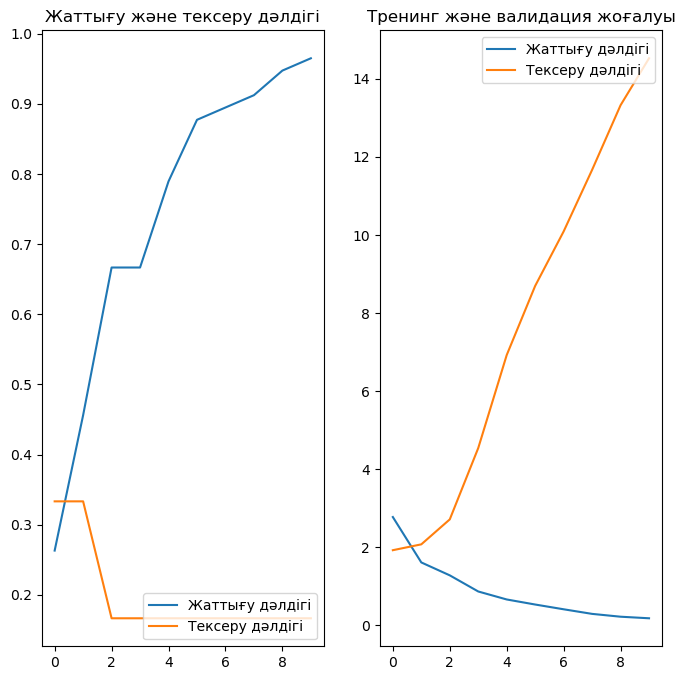

In [94]:
acc = history_resnet50.history['accuracy']
val_acc = history_resnet50.history['val_accuracy']

loss = history_resnet50.history['loss']
val_loss = history_resnet50.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Жаттығу дәлдігі')
plt.plot(epochs_range, val_acc, label='Тексеру дәлдігі')
plt.legend(loc='lower right')
plt.title('Жаттығу және тексеру дәлдігі')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Жаттығу дәлдігі')
plt.plot(epochs_range, val_loss, label='Тексеру дәлдігі')
plt.legend(loc='upper right')
plt.title('Тренинг және валидация жоғалуы')
plt.show()

#### Resnet 50 үлгісінің дәлдігі 

In [95]:
test_loss_resnet50, test_accuracy_resnet50 = resnet50_model.evaluate(val_ds)
print(f"ResNet-50 тестілеу дәлдігі: {test_accuracy_resnet50 * 100:.2f}%")

1/1 [==============================] - 0s 438ms/step - loss: 14.5240 - accuracy: 0.1667
ResNet-50 тестілеу дәлдігі: 16.67%


#### MobileNetV2 қолданылған CNN алгоритмін құру

In [125]:
def create_mobilenetv2_model(input_shape=(224, 224, 3), num_classes=7, dropout_rate=0.3):
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False  

    model = Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),  
        layers.Dropout(dropout_rate),  
        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), 
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

mobilenetv2_model = create_mobilenetv2_model()

# Compile the model
mobilenetv2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
mobilenetv2_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_9  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_59 (Dense)            (None, 1024)              1311744   
                                                                 
 batch_normalization_58 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dropout_39 (Dropout)        (None, 1024)              0         
                                                     

In [126]:
mobilenetv2_model = create_mobilenetv2_model(input_shape=(img_height, img_width, 3), num_classes=7)
mobilenetv2_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Құрылған үлгіні оқыту

In [127]:
history_mobilenetv2 = mobilenetv2_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
2/2 [==============================] - 7s 2s/step - loss: 4.7942 - accuracy: 0.2157 - val_loss: 3.6599 - val_accuracy: 0.1667
Epoch 2/10
2/2 [==============================] - 1s 622ms/step - loss: 2.6434 - accuracy: 0.7059 - val_loss: 3.7189 - val_accuracy: 0.1667
Epoch 3/10
2/2 [==============================] - 1s 486ms/step - loss: 2.3345 - accuracy: 0.7647 - val_loss: 3.7748 - val_accuracy: 0.1667
Epoch 4/10
2/2 [==============================] - 1s 480ms/step - loss: 1.9750 - accuracy: 0.9608 - val_loss: 3.8489 - val_accuracy: 0.1667
Epoch 5/10
2/2 [==============================] - 1s 507ms/step - loss: 1.9909 - accuracy: 0.9020 - val_loss: 3.8639 - val_accuracy: 0.1667
Epoch 6/10
2/2 [==============================] - 1s 479ms/step - loss: 1.8967 - accuracy: 0.9412 - val_loss: 3.9627 - val_accuracy: 0.1667
Epoch 7/10
2/2 [==============================] - 1s 501ms/step - loss: 1.9230 - accuracy: 0.9020 - val_loss: 4.0798 - val_accuracy: 0.0833
Epoch 8/10
2/2 [=======

#### Оқыту және тексеру дәлдігін, сондай-ақ дәуірлердегі оқыту мен тексерудің жоғалуын визуализациялау үшін екі ішкі сызбаны жасау

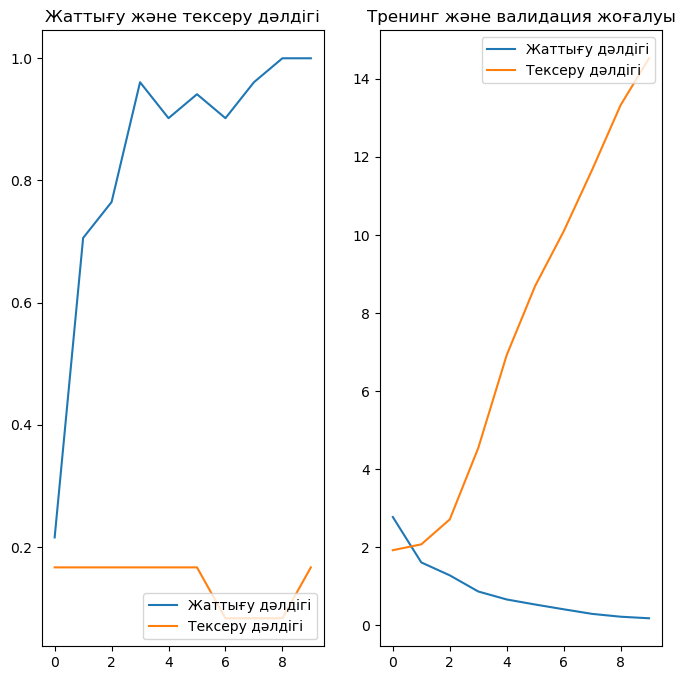

In [128]:
acc = history_mobilenetv2.history['accuracy']
val_acc = history_mobilenetv2.history['val_accuracy']

loss = history_resnet50.history['loss']
val_loss = history_resnet50.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Жаттығу дәлдігі')
plt.plot(epochs_range, val_acc, label='Тексеру дәлдігі')
plt.legend(loc='lower right')
plt.title('Жаттығу және тексеру дәлдігі')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Жаттығу дәлдігі')
plt.plot(epochs_range, val_loss, label='Тексеру дәлдігі')
plt.legend(loc='upper right')
plt.title('Тренинг және валидация жоғалуы')
plt.show()

####  MobileNetV2 үлгісінің дәлдігі

In [129]:
test_loss_mobilenetv2, test_accuracy_mobilenetv2 = mobilenetv2_model.evaluate(val_ds)
print(f"MobileNetV2 тестілеу дәлдігі: {test_accuracy_mobilenetv2 * 100:.2f}%")

1/1 [==============================] - 0s 232ms/step - loss: 4.1673 - accuracy: 0.1667
MobileNetV2 тестілеу дәлдігі: 16.67%


#### Дәлдік графигі

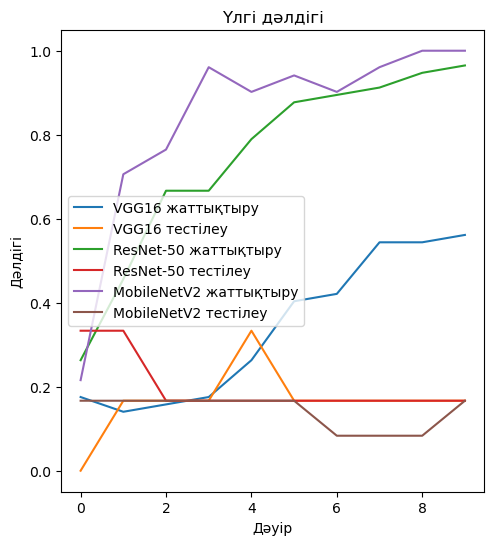

In [130]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.plot(history.history['accuracy'], label='VGG16 жаттықтыру')
plt.plot(history.history['val_accuracy'], label='VGG16 тестілеу')

plt.plot(history_resnet50.history['accuracy'], label='ResNet-50 жаттықтыру')
plt.plot(history_resnet50.history['val_accuracy'], label='ResNet-50 тестілеу')

plt.plot(history_mobilenetv2.history['accuracy'], label='MobileNetV2 жаттықтыру')
plt.plot(history_mobilenetv2.history['val_accuracy'], label='MobileNetV2 тестілеу')

plt.title('Үлгі дәлдігі')
plt.xlabel('Дәуір')
plt.ylabel('Дәлдігі')
plt.legend()

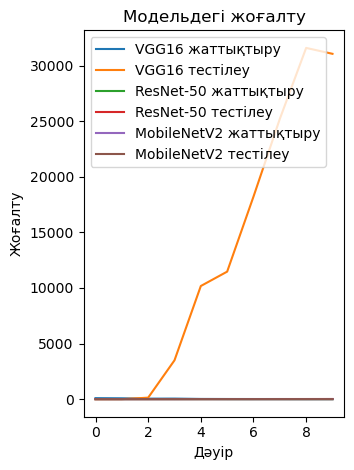

In [131]:
plt.subplot(1, 2, 2)

plt.plot(history.history['loss'], label='VGG16 жаттықтыру')
plt.plot(history.history['val_loss'], label='VGG16 тестілеу')

plt.plot(history_resnet50.history['loss'], label='ResNet-50 жаттықтыру')
plt.plot(history_resnet50.history['val_loss'], label='ResNet-50 тестілеу')

plt.plot(history_mobilenetv2.history['loss'], label='MobileNetV2 жаттықтыру')
plt.plot(history_mobilenetv2.history['val_loss'], label='MobileNetV2 тестілеу')

plt.title('Модельдегі жоғалту')
plt.xlabel('Дәуір')
plt.ylabel('Жоғалту')
plt.legend()

plt.tight_layout()
plt.show()

### Модельді бағалау

In [117]:
def evaluate_model(model, test_ds):
    y_true = []
    y_pred = []

    for images, labels in test_ds:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))

    class_names = [str(i) for i in range(7)] 

    report = classification_report(y_true, y_pred, target_names=class_names)
    print(f"Model Evaluation:\n{report}")

#### VGG16 үлгісін бағалау

In [118]:
evaluate_model(vgg16_model, val_ds)

1/1 [==============================] - 2s 2s/step
Model Evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         2
           5       0.08      1.00      0.15         1
           6       0.00      0.00      0.00         1

    accuracy                           0.08        12
   macro avg       0.01      0.14      0.02        12
weighted avg       0.01      0.08      0.01        12



C:\Users\assai\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\assai\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\assai\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### ResNet-50 моделін бағалау 

In [119]:
evaluate_model(resnet50_model, val_ds)

1/1 [==============================] - 4s 4s/step
Model Evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       2.0
           3       0.00      0.00      0.00       4.0
           4       0.00      0.00      0.00       2.0
           5       0.00      0.00      0.00       1.0
           6       0.00      0.00      0.00       1.0

    accuracy                           0.00      12.0
   macro avg       0.00      0.00      0.00      12.0
weighted avg       0.00      0.00      0.00      12.0



C:\Users\assai\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\assai\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\assai\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### MobileNetV2 үлгісін бағалау

In [132]:
evaluate_model(mobilenetv2_model, val_ds)

1/1 [==============================] - 1s 1s/step
Model Evaluation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         4
           4       0.67      1.00      0.80         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1

    accuracy                           0.17        12
   macro avg       0.10      0.14      0.11        12
weighted avg       0.11      0.17      0.13        12



C:\Users\assai\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\assai\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\assai\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Бар графигі

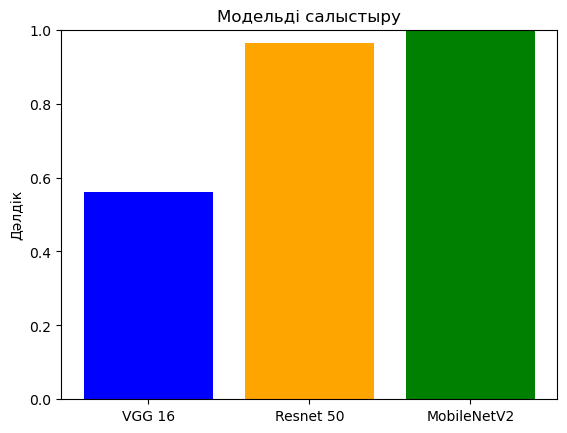

In [133]:
models = ['VGG 16', 'Resnet 50', 'MobileNetV2']

accuracies = [
    history.history['accuracy'][-1],
    history_resnet50.history['accuracy'][-1],
    history_mobilenetv2.history['accuracy'][-1]
]

plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)
plt.title('Модельді салыстыру')
plt.ylabel('Дәлдік')
plt.show()

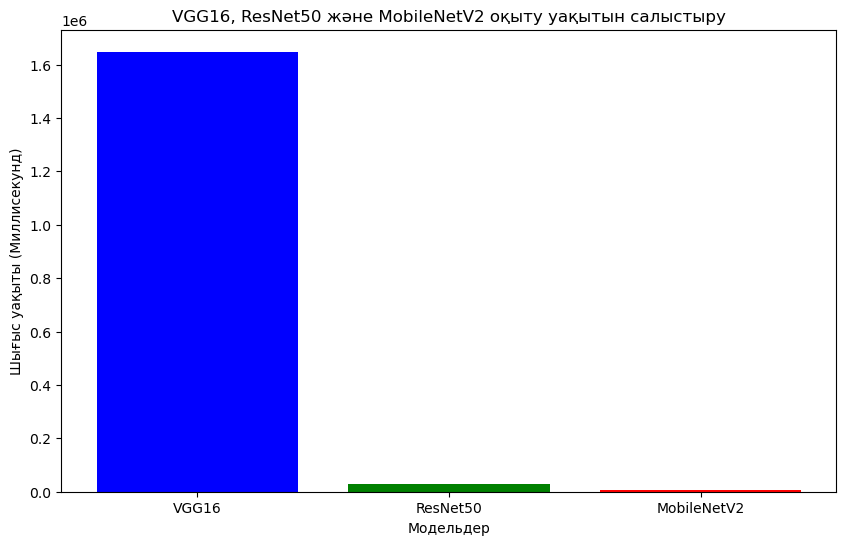

In [153]:
train_times = [1648000, 28000, 6532]

models = ['VGG16', 'ResNet50', 'MobileNetV2']

plt.figure(figsize=(10, 6))
plt.bar(models, train_times, color=['blue', 'green', 'red'])
plt.xlabel('Модельдер')
plt.ylabel('Шығыс уақыты (Миллисекунд)')
plt.title('VGG16, ResNet50 және MobileNetV2 оқыту уақытын салыстыру')
plt.show()

#### Тестілеу

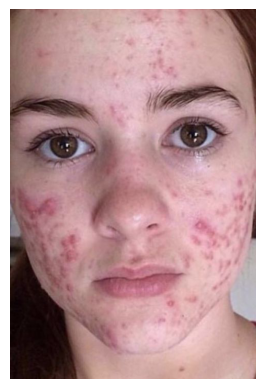

1/1 [==============================] - 0s 53ms/step
VGG 16
Бұл сурет Ospa -қа  ұқсайды. Сенімділік: 0.31 - пайызға тең.
Resnet 50
Бұл сурет Akne -қа  ұқсайды. Сенімділік: 0.30 - пайызға тең.
MobileNetV2
Бұл сурет Akne -қа  ұқсайды. Сенімділік: 0.24 - пайызға тең.


In [148]:
bezeu_path = r"C:\Users\assai\suret001.jpg"

img = mpimg.imread(bezeu_path)
imgplot = plt.imshow(img)
plt.axis('off') 
plt.show()

img = tf.keras.utils.load_img(
    bezeu_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# vgg16
VGG16predictions = vgg16_model.predict(img_array)
VGG16score = tf.nn.softmax(tf.reshape(tf.convert_to_tensor(VGG16predictions[0], dtype=tf.float32), [-1]))

# Resnet50
Resnet50predictions = resnet50_model.predict(img_array)
Resnet50score = tf.nn.softmax(tf.reshape(tf.convert_to_tensor(Resnet50predictions[0], dtype=tf.float32), [-1]))

# MobileNetV2
MobileNetV2predictions = mobilenetv2_model.predict(img_array)
MobileNetV2score = tf.nn.softmax(tf.reshape(tf.convert_to_tensor(MobileNetV2predictions[0], dtype=tf.float32), [-1]))

print("VGG 16")
print(
    "Бұл сурет {} -қа  ұқсайды. Сенімділік: {:.2f} - пайызға тең."
    .format(class_names[np.argmax(VGG16score)], np.max(VGG16score))
)

print("Resnet 50")
print(
    "Бұл сурет {} -қа  ұқсайды. Сенімділік: {:.2f} - пайызға тең."
    .format(class_names[np.argmax(Resnet50score)], np.max(Resnet50score))
)

print("MobileNetV2")
print(
    "Бұл сурет {} -қа  ұқсайды. Сенімділік: {:.2f} - пайызға тең."
    .format(class_names[np.argmax(MobileNetV2score)], np.max(MobileNetV2score.numpy()))
)

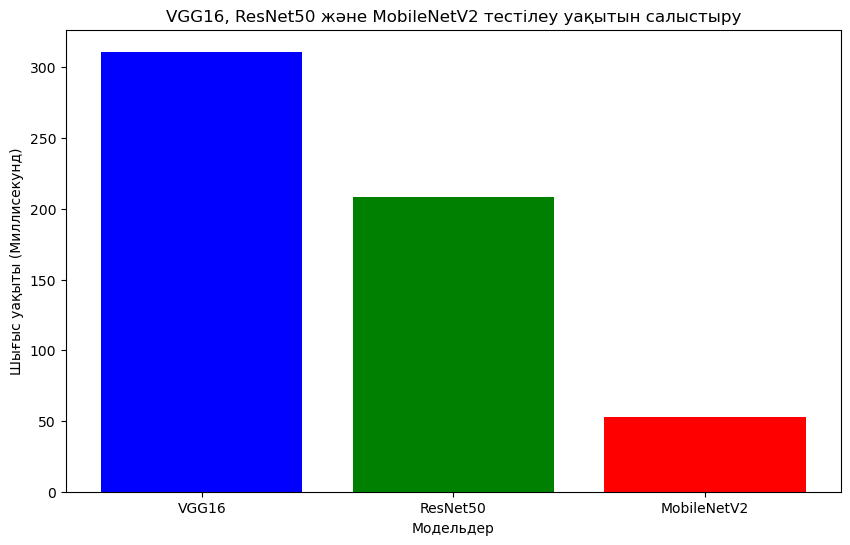

In [154]:
inference_times = [311, 208, 53]

models = ['VGG16', 'ResNet50', 'MobileNetV2']

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times, color=['blue', 'green', 'red'])
plt.xlabel('Модельдер')
plt.ylabel('Шығыс уақыты (Миллисекунд)')
plt.title('VGG16, ResNet50 және MobileNetV2 тестілеу уақытын салыстыру')
plt.show()

#### Ең жақсы көрсеткіш көрсеткен модельді сақтау 

Жоғарыда жасалынған жұмыстар бойынша, қолданылған модельдер келесі көрсеткіштер көрсетті.

VGG 16 - 31 % және де Оспа ауруын көрсетті. Бұл қате көрсеткіш.

Resnet 50 - 30 % және де Акне ауруын көрсетті. Бұл дұрыс көрсеткіш. Бірақ бұл модельді оқыту және тестілеу өте ұзақ уақытты алды.

MobileNetV2 - 24% және де Акне ауруын көрсетті. Бұл дұрыс көрсеткіш. Және ең жылдам оқытылған және тестіленген модель.

Оқытылған модельдерден MobileNetV2 дұрыс және ең жақсы көрсеткіш көрсетті.

Интелектуалды қосымша жасау үшін бұл модельді сақтаймыз.

In [36]:
mobilenetv2_model.save(r'C:\Users\assai\Dermotology_Auru.h5')

C:\Users\assai\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
